# 東京の感染者数

データは  
https://stopcovid19.metro.tokyo.lg.jp/data/130001_tokyo_covid19_patients.csv  
を使わせていただく。  
まず、データフレームに格納。その際に「公表_年月日」のカラムを日付として解釈しておく。

In [56]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('https://stopcovid19.metro.tokyo.lg.jp/data/130001_tokyo_covid19_patients.csv', 
                 parse_dates=['公表_年月日'])

df.head()

,No,全国地方公共団体コード,都道府県名,市区町村名,公表_年月日,曜日,発症_年月日,患者_居住地,患者_年代,患者_性別,患者_属性,患者_状態,患者_症状,患者_渡航歴の有無フラグ,備考,退院済フラグ
0,1,130001,東京都,NaN,2020-01-24,金,NaN,湖北省武漢市,40代,男性,NaN,NaN,NaN,NaN,NaN,1.0
1,2,130001,東京都,NaN,2020-01-25,土,NaN,湖北省武漢市,30代,女性,NaN,NaN,NaN,NaN,NaN,1.0
2,3,130001,東京都,NaN,2020-01-30,木,NaN,湖南省長沙市,30代,女性,NaN,NaN,NaN,NaN,NaN,1.0
3,4,130001,東京都,NaN,2020-02-13,木,NaN,都内,70代,男性,NaN,NaN,NaN,NaN,NaN,1.0
4,5,130001,東京都,NaN,2020-02-14,金,NaN,都内,50代,女性,NaN,NaN,NaN,NaN,NaN,1.0


## 日付ごとの集計
データフレームの日付の出現を数えて、日毎の感染者数とする。同時に累積の感染者数も計算しておく。

In [57]:
date = []
daily_case = []
total_case = []
current_accum_case = 0
for k, v in df["公表_年月日"].value_counts().sort_index().items():
    date.append(k)
    daily_case.append(v)
    current_accum_case += v
    total_case.append(current_accum_case)

日毎の感染者数と累積の感染者数をカラムにもつデータフレームを作成。

In [58]:
df_daily = pd.DataFrame(
    {"daily_case": daily_case,
     "total_case": total_case},
    index = date
)
df_daily.head()

,daily_case,total_case
2020-01-24,1,1
2020-01-25,1,2
2020-01-30,1,3
2020-02-13,1,4
2020-02-14,2,6


感染者が発見されていない日のデータが存在しないので、そのような日の行を含むデータフレームにしておく。

In [59]:
df_daily =df_daily.resample("1D").asfreq()
df_daily.head()

,daily_case,total_case
2020-01-24,1.0,1.0
2020-01-25,1.0,2.0
2020-01-26,NaN,NaN
2020-01-27,NaN,NaN
2020-01-28,NaN,NaN


追加された行のデータが存在しないので、NaNとなっている。新規感染者のNaNは0に、累積のNaNは一つ上の行と同じとしておく。

In [60]:
df_daily["daily_case"].fillna(0, inplace=True)
df_daily["total_case"].ffill(inplace=True)
df_daily.head()

,daily_case,total_case
2020-01-24,1.0,1.0
2020-01-25,1.0,2.0
2020-01-26,0.0,2.0
2020-01-27,0.0,2.0
2020-01-28,0.0,2.0


In [61]:
df["曜日"].value_counts()

金    1050
土    1030
木     861
日     826
火     769
水     695
月     552
Name: 曜日, dtype: int64

報告数は月火水は少なくなる傾向があるようなので、7日間の移動平均を格納しておく。



In [62]:
df_daily["7day_MA"] = df_daily.rolling(7).mean()["daily_case"]
df_daily.tail()

,daily_case,total_case,7day_MA
2020-06-17,16.0,5633.0,29.857143
2020-06-18,41.0,5674.0,32.571429
2020-06-19,35.0,5709.0,34.000000
2020-06-20,39.0,5748.0,36.142857
2020-06-21,35.0,5783.0,34.428571


## 日毎の感染者数のプロット

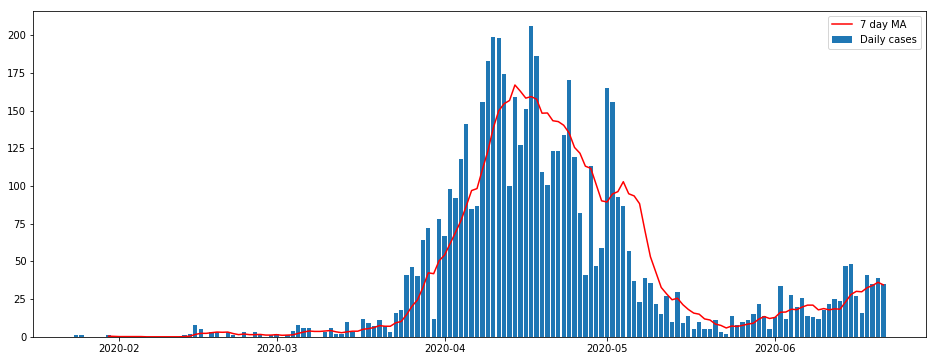

In [63]:
fig = plt.figure(figsize=(16.0, 6.0))
ax = fig.add_subplot(111)
ax.bar(df_daily.index, df_daily["daily_case"], label="Daily cases")
ax.plot(df_daily.index, df_daily["7day_MA"], color="red", label="7 day MA")
ax.legend()

plt.show()

## 累積の感染者数のプロット

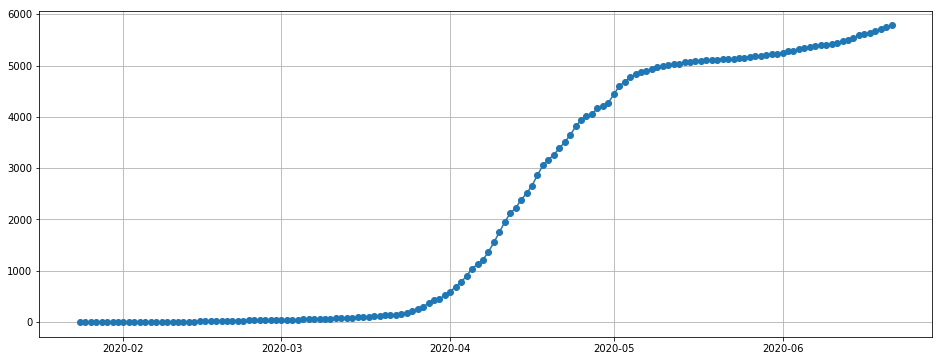

In [64]:
fig = plt.figure(figsize=(16.0, 6.0))
ax = fig.add_subplot(111)
plt.plot(df_daily.index, df_daily["total_case"],marker='o')
ax.grid()

plt.show()

## 累積の感染者数のプロット（対数軸）

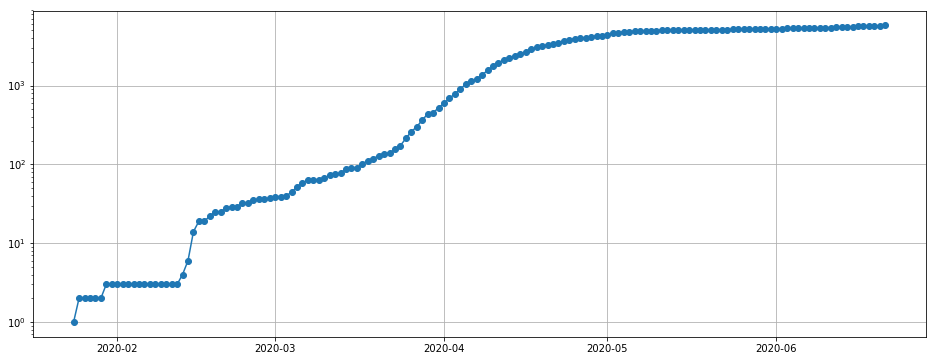

In [65]:
fig = plt.figure(figsize=(16.0, 6.0))
ax = fig.add_subplot(111)
ax.set_yscale('log')
plt.plot(df_daily.index, df_daily["total_case"],marker='o')
ax.grid()

plt.show()

# K値の推移をプロットする

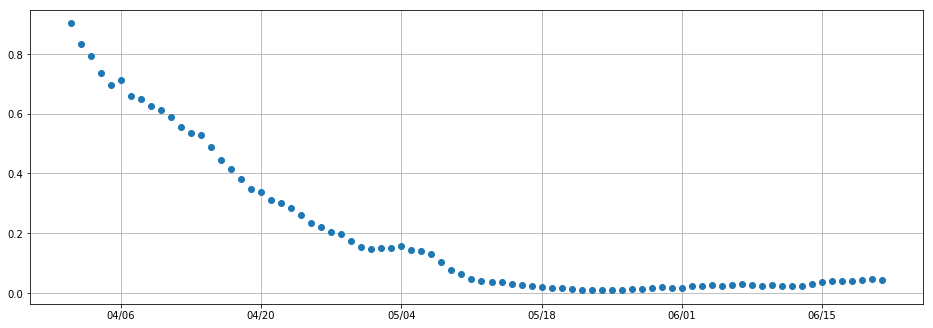

             K_value
2020-04-01  0.902381
2020-04-02  0.832046
2020-04-03  0.791803
2020-04-04  0.737637
2020-04-05  0.697353
             K_value
2020-06-17  0.038278
2020-06-18  0.041447
2020-06-19  0.042991
2020-06-20  0.045381
2020-06-21  0.042959


In [66]:
import datetime
import matplotlib.dates as mdates

def calc_k_value(df, date):
    today = date
    one_week_ago = today - datetime.timedelta(days=7)
    
    total_as_of_today = df.loc[today]
    total_as_of_one_week_ago = df.loc[one_week_ago]
    
    return 1 - (total_as_of_one_week_ago/total_as_of_today)

def plot_k_value(df, start_date):
    last_date = df.index.max()
    offset_date = start_date - datetime.timedelta(days=8)
    offset = df.loc[offset_date]["total_case"]
    offset_cases = (df["total_case"] - offset)
    
    index = pd.date_range(start_date, last_date, freq='D')
    k_values = [calc_k_value(offset_cases, i) for i in index]

    df_k = pd.DataFrame({"K_value": k_values}, index=index)
 
    fig = plt.figure(figsize=(16.0, 6.0))
    ax = fig.add_subplot(111)
    
    days    = mdates.DayLocator(bymonthday=None, interval=14) 
    daysFmt = mdates.DateFormatter('%m/%d') 
    ax.xaxis.set_major_locator(days) 
    ax.xaxis.set_major_formatter(daysFmt) 
    fig.autofmt_xdate() 
    ax.grid()

    plt.plot(df_k.index, df_k["K_value"], marker='o', linestyle="None")

    plt.show()
    print(df_k.head())
    print(df_k.tail())

plot_k_value(df_daily, datetime.date(2020, 4, 1))